## Training to advection/convection term

In [7]:
#imports
import jax
import jax.numpy as jnp

import jax_cfd.base as cfd
from jax_cfd.base import advection
from jax_cfd.ml import towers
import jax_cfd.ml.train_utils as train_utils
from jax_cfd.base import finite_differences as fd
from jax_cfd.base import grids

import haiku as hk
import numpy as np
import xarray
import random

import pickle
# from jax_cfd.ml.diego_model_utils import SaveObject, forward_pass_module
import jax_cfd.ml.diego_preprocessing as preprocessing
import jax_cfd.ml.diego_train_functions as training
from jax_cfd.ml import nonlinearities
import jax_cfd.ml.diego_cnn_bcs as bcs

import jax_cfd.ml.newSaveObject as saving
import jax_cfd.ml.diego_towers as mytowers

import matplotlib.pyplot as plt
import seaborn

import time

In [2]:
# this allows me to reload a module without having to interrupt the kernel
# import importlib
# importlib.reload()
# importlib.reload(from jax_cfd.ml.diego_train_functions import *)
# importlib.reload(from jax_cfd.ml import nonlinearities)
# importlib.reload(from jax_cfd.ml.diego_cnn_bcs import *)

In [3]:
# import data (fine grid)
# create X_data via mean pooling
# create Y_data by calculating everything for each frame and stacking them along the channel dimension

In [3]:
# import data
file_name = '256x64_150_seconds_inner_1'
data = xarray.open_dataset(f'../../creating_dataset/datasets/'+ file_name +'.nc', chunks={'time': '100MB'})

In [4]:
# split by timestamps
x_shape = len(data.x)
y_shape = len(data.y)
high_def = []
for i in range(int(len(data.time))):
    this_time = np.dstack([
        jnp.array([data.u.isel(time = i)]).reshape(x_shape,y_shape).T,
        jnp.array([data.v.isel(time = i)]).reshape(x_shape,y_shape).T
    ])
    high_def.append(this_time)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [5]:
#warm up time (may want to discard initial stages of simulation since not really representative of turbulent flow?)
dt = float(data.time[0].values)

outer_steps = len(data.time.values)

inner_steps = (data.time[1].values-data.time[0].values)/dt

total_sim_time = outer_steps*inner_steps*dt
print("dt: \t\t" + str(dt))
print("outer_steps: \t" + str(outer_steps))
print("inner_steps: \t" + str(inner_steps))
print("total_sim_time: " + str(total_sim_time))

warm_up = 15 #seconds
warm_index = int(warm_up/total_sim_time * outer_steps // 1)
print("removed points: " + str(warm_index))
high_def = high_def[warm_index:]

print("\n")
step = 100
high_def = high_def[0::step]
print("step = " + str(step))
print("Training dataset shape: ") # (frames, x, y, input channels)
print("\t" + str(np.shape(high_def)))

dt: 		0.015625
outer_steps: 	9600
inner_steps: 	1.0
total_sim_time: 150.0
removed points: 960


step = 100
Training dataset shape: 
	(87, 64, 256, 2)


In [6]:
%time high_def_norm,ogMean,ogStdDev = preprocessing.normalisingDataset(high_def)

CPU times: user 15.5 ms, sys: 962 µs, total: 16.4 ms
Wall time: 25.4 ms


In [8]:
testing_data = high_def[:5]

In [9]:
def convect(v):  # pylint: disable=function-redefined
      return tuple(
          advection.advect_van_leer_using_limiters(u, v, dt) for u in v)

In [37]:
# convect(testing_data[0])

diego = (grids.GridVariable(array = grids.GridArray(data = testing_data[0][:,:,0], 
                                            offset = (1.0, 0.5), 
                                            grid=grids.Grid(
                                                shape=(256, 64),  
                                                domain=((0.0, 8.0), (0.0, 2.0)) ) ),
#                        bc=cfd.boundaries.channel_flow_boundary_conditions(ndim=2)
                        bc = cfd.boundaries.periodic_boundary_conditions(2)
                   ),
 grids.GridVariable(array = grids.GridArray(data = testing_data[1][:,:,0], 
                                            offset = (0.5, 1.0),
                                            grid=grids.Grid(
                                                shape=(256, 64),  
                                                domain=((0.0, 8.0), (0.0, 2.0)) ) ),
#                        bc=cfd.boundaries.channel_flow_boundary_conditions(ndim=2)
                        bc = cfd.boundaries.periodic_boundary_conditions(2)
                   )
)
convect(diego)
# cfd.boundaries.periodic_boundary_conditions(2)

ValueError: the GridArray does not contain all interior grid values.

HomogeneousBoundaryConditions(types=(('periodic', 'periodic'), ('dirichlet', 'dirichlet')), bc_values=((0.0, 0.0), (0.0, 0.0)))

In [15]:
#split into train and test

split = 0.8
split = int(len(high_def)*split//1)
random.shuffle(high_def)

factor = 4

print("Create X dataset: ")
%time X_dataset = preprocessing.creatingDataset(high_def_norm,preprocessing.sampling,factor)

print("\nCreate Y dataset: ")
padding = [1,1]
%time Y_dataset = preprocessing.getYdata(high_def_norm,which_outputs,padding,preprocessing.sampling,factor) #does everything, returns unpadded data

# %time Y_dataset = calculateResiduals(X_dataset,Y_dataset)


X_train = X_dataset[:split]
Y_train = Y_dataset[:split]

X_test = X_dataset[split:]
Y_test = Y_dataset[split:]



# print("\nPadding all datasets: ")
# padding = [1,1] #this is for a 3 by 3 kernel, find a better way to define this (so not redifined when creating CNN)
# %time X_train = padXDataset(X_train,padding)
# %time Y_train = padYDatasetNew(Y_train,padding,conditions)

# %time X_test = padXDataset(X_test,padding)
# %time Y_test = padYDataset(Y_test,padding,conditions)

print("\nShapes of all datasets")
training.printAllShapes(X_train,Y_train, X_test,Y_test)

Create X dataset: 
CPU times: user 15.6 ms, sys: 1.03 ms, total: 16.7 ms
Wall time: 15.8 ms

Create Y dataset: 
CPU times: user 2.26 s, sys: 3.87 ms, total: 2.27 s
Wall time: 2.28 s

Shapes of all datasets
(69, 16, 64, 2)
(69, 16, 64, 2)
(18, 16, 64, 2)
(18, 16, 64, 2)


## Defining model shape

In [64]:
def ConvNet(x):
    cnn = mytowers.CNN(CNN_specs)
    return cnn(x)

CNN_specs = {
    "hidden_channels" : 10,
    "hidden_layers" : 6,
    "nonlinearity" : "relu",
    "num_output_channels" : 2
}
input_channels = 2

# CNN_specs = None

In [65]:
forward_pass = hk.without_apply_rng(hk.transform(ConvNet))

In [66]:
instance = training.MyTraining(X_train,Y_train,X_test,Y_test,
                      jax.random.PRNGKey(42), #rng_key
                      input_channels=2,
                      epochs = 5,
                      printEvery=1,#epochs
                      learning_rates=training.staggeredLearningRate((50,0.1),(20,0.01),(11,0.001)), #iterated over batches
                      batch_size=len(X_train)//2+1, # number or len(X_train)
                      validateEvery=1,
                      params=None,
                      forward_pass=forward_pass,
                      tol = 1e-10)

%time instance.train()

Shapes of all datasets
(69, 16, 64, 2)
(69, 16, 64, 2)
(18, 16, 64, 2)
(18, 16, 64, 2)



Start time: 18:18:21
Epoch 1/5
	mse : 0.009987		val mse : 0.009665	Estimated end time: 18:18:39


Epoch 2/5
	mse : 0.008756		val mse : 0.008784	Estimated end time: 18:18:45


Epoch 3/5
	mse : 0.008196		val mse : 0.008350	Estimated end time: 18:18:48


Epoch 4/5
	mse : 0.007908		val mse : 0.008112	Estimated end time: 18:18:50


Epoch 5/5
	mse : 0.007745		val mse : 0.007968	Estimated end time: 18:18:51



Finished training at max epochs

CPU times: user 38.5 s, sys: 433 ms, total: 38.9 s
Wall time: 30.4 s


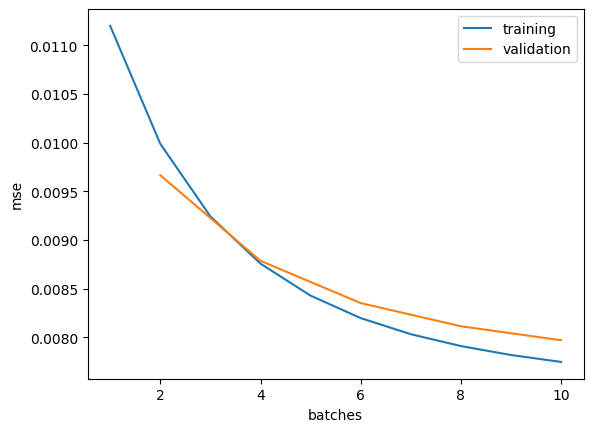

In [29]:

batches = np.arange(len(instance.losses))
val_step = len(instance.losses)//len(instance.val_losses)

batches_val = batches[::val_step]+val_step
plt.plot(batches+1,instance.losses, label="training")
plt.plot(batches_val,instance.val_losses,label="validation")
plt.ylabel("mse")
plt.xlabel("batches")
# plt.yscale("log")
plt.legend()

In [41]:
description = "30 sec training, 0.1 learning rate, wider network"

In [44]:
toSave = saving.newSaveObject(instance.params,instance.losses,instance.val_losses,description,CNN_specs)

In [45]:
with open(save_path,"wb") as f:
    pickle.dump(toSave,f)

del save_path

In [47]:
save_path = "./../models/correctors/laplacian_correctors/testing.pickle"

## Loading model

In [48]:
with open(save_path,'rb',) as pickle_file:
    loaded = pickle.load(pickle_file)
    CNN_specs = loaded.CNN_specs
    loaded.forward_pass = hk.without_apply_rng(hk.transform(ConvNet))

In [49]:
loaded.description

'30 sec training, 0.1 learning rate, wider network'

## Evaluating the model 

In [50]:
# loss_eval = mse
def loss_eval(in1,in2):
    return abs(in1-in2)

In [51]:
# Make predictions for every slice in X_test
predictions = []
for mySlice in X_test:
    predictions.append(loaded.forward_pass.apply(loaded.params,mySlice))

In [52]:
# Compute error predictions vs Y_test
errors = []
for j in range(len(predictions)):
    partial = []
    partial.append(loss_eval(predictions[j],Y_test[j]))
#     partial.append(mape(predictions[j],Y_test[j]))
    errors.append(partial)

In [53]:
# Compute what would have been obtained from input without the CNN (to see if there is an improvement)

In [55]:
# calculate laplacians for input
inputLaps = []
for j in range(len(X_test)):
    inputLaps.append(preprocessing.npLaplacian(X_test[j]))

In [56]:
# Compute error computed laps for input vs true laps
errorsLaps = []
for j in range(len(predictions)):
    partial = []
    partial.append(loss_eval(inputLaps[j],Y_test[j]))
#     partial.append(mape(predictions[j],Y_test[j]))
    errorsLaps.append(partial)

In [57]:
print("Test error for NN")
print("\tError : {:.6f}".format(np.mean(errors)))
print("\tError/mean(||truth||) : {:.6f}".format(np.mean(errors) / np.mean(np.abs(Y_test))))

print("\nError if no NN used")
print("\tError : {:.6f}".format(np.mean(errorsLaps)))
print("\tError/mean(||truth||) : {:.6f}".format(np.mean(errorsLaps) / np.mean(np.abs(Y_test))))

Test error for NN
	Error : 0.048276
	Error/mean(||truth||) : 1.186088

Error if no NN used
	Error : 0.245808
	Error/mean(||truth||) : 6.039196
